In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/dinhviettoanle/neural_style_transfer_notebook.git

Cloning into 'neural_style_transfer_notebook'...
remote: Enumerating objects: 95, done.
remote: Total 95 (delta 0), reused 0 (delta 0), pack-reused 95
Receiving objects: 100% (95/95), 85.05 MiB | 47.51 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [14]:
cd /content/neural_style_transfer_notebook

/content/neural_style_transfer_notebook


In [15]:
!mkdir train
!unzip -q /content/drive/MyDrive/val2017.zip -d train

!mkdir models
!rm -rf sample_data

mv: cannot stat 'data/utils.py': No such file or directory
rm: cannot remove 'data': No such file or directory
mkdir: cannot create directory ‘models’: File exists


In [23]:
def gram_matrix(y):
    """Computes the Gram matrix of a set of feature maps"""
    (b, ch, h, w) = y.size() # batch, channels, height, width
    # Flatten the feature map
    features = y.view(b, ch, w * h)
    # Transpose the flatten matrix without modifying the batch and channel dimensions
    features_t = features.transpose(1, 2)
    # Batch-matrix-multiplication and normalization by channels*height*width
    gram = features.bmm(features_t) / (ch*h*w)
    return gram

In [24]:
class GramMSELoss(nn.Module):
    def forward(self, feature, target):
        out = nn.MSELoss()(gram_matrix(feature), target)
        return out

In [17]:
# ===== Hyper-parameters =====
image_size = 128
dataset = "train"
lr = 1e-2
batch_size = 5
style_image = "/content/train/candy.jpg"
epochs = 20
content_weight = 1e4
style_weight = 1e8
# ============================

In [18]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [19]:
def normalize_batch(batch):
    # Normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [20]:
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
style = Image.open(style_image).convert('RGB')
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

In [21]:
vgg16 = utils.initialize_pretrained_vgg16().to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 269MB/s]


In [25]:
style_layers = ['r12','r22','r33','r43']
style_targets = [gram_matrix(feature) for feature in vgg16(style, style_layers)]
loss_fn_style = GramMSELoss().to(device)

content_layers = ['r22']
loss_fn_content = nn.MSELoss().to(device)

loss_layers = style_layers + content_layers

In [26]:
model = utils.ImageTransformNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

for e in range(epochs):
    model.train()
    agg_content_loss = 0
    agg_style_loss = 0
    count = 0

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {e+1}/{epochs}", leave=False)
    utils.print_head()

    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch

        # Set gradients of out_img at zero
        optimizer.zero_grad()

        x = x.to(device)
        y = model(x)

        # `feature_a` is a list of tensors, corresponding to each feature maps indexed by loss_layers
        features_y = vgg16(normalize_batch(y), loss_layers)
        features_x = vgg16(normalize_batch(x), loss_layers)

        # Retrieve style_losses and content_losses
        style_losses = []
        content_losses = []
        for feat_i, feature in enumerate(features_y):
            if feat_i < len(style_layers):
                gram_feat_i = style_targets[feat_i] # Get the batch of Gram matrices corresponding to this feature
                style_losses.append(style_weight * loss_fn_style(feature, gram_feat_i[:n_batch, :, :]))
            else:
                content_losses.append(content_weight * loss_fn_content(feature, features_x[feat_i]))

        # The total loss is the sum of style and content losses
        content_loss = sum(content_losses)
        style_loss = sum(style_losses)
        total_loss = content_loss + style_loss

        # Updates the model
        total_loss.backward()
        optimizer.step()

        # Log
        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % 10 == 0:
            avg_content_loss = agg_content_loss / (batch_id + 1)
            avg_style_loss = agg_style_loss / (batch_id + 1)
            avg_total_loss = avg_content_loss + avg_style_loss
            utils.print_log(e, avg_content_loss, avg_style_loss, avg_total_loss, count, len(train_dataset))

        if (batch_id + 1) % 100 == 0:
            model.eval().cpu()
            save_model_filename = f"models/epoch_{e+1}_checkpoint_{batch_id+1}.pth"
            torch.save(model.state_dict(), save_model_filename)
            model.to(device).train()


        pbar.update(1)
    pbar.close()
    print()


    # Save model
    model.eval().cpu()
    save_model_filename = "models/epoch_" + str(e+1) + ".pth"
    torch.save(model.state_dict(), save_model_filename)
    model.to(device).train()

Epoch 1/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Timestamp             Epoch     Count       		Content loss        Style loss          Total loss          
2023-11-12 17:31:10   1         [40  / 5000]		747670.1            4834126.1           5581796.2           
2023-11-12 17:31:40   1         [80  / 5000]		788832.2            4211828.0           5000660.2           
2023-11-12 17:32:09   1         [120 / 5000]		823176.8            3934380.8           4757557.6           
2023-11-12 17:32:41   1         [160 / 5000]		827130.3            3767377.4           4594507.7           
2023-11-12 17:33:11   1         [200 / 5000]		839900.7            3637989.1           4477889.8           
2023-11-12 17:33:41   1         [240 / 5000]		826719.2            3537638.7           4364357.9           
2023-11-12 17:34:11   1         [280 / 5000]		836274.3            3451941.3           4288215.6           
2023-11-12 17:34:41   1         [320 / 5000]		831684.5            3383121.6           4214806.0           
2023-11-12 17:35:11   1         [360 

KeyboardInterrupt: ignored

In [ ]:
content_image_filename = "/content/image1.jpg"
# model = "saved_models/udnie.pth"
# model = "saved_models/mosaic.pth"
model = "models/epoch_10.pth"

In [ ]:
# Load and transform the image
content_image = Image.open(content_image_filename).convert('RGB')
content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

# Apply the style model
with torch.no_grad():
    style_model = utils.load_model(model).to(device)
    output = style_model(content_image).cpu()[0]

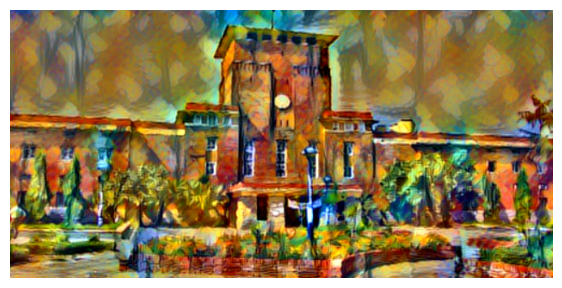

In [32]:
utils.show_image_johnson(output)
plt.gcf().set_size_inches(7, 7)
